In [1]:
# @title Install dependencies
#!pip install numpy Pillow matplotlib torch torchvision transformers gradio sentencepiece trdg protobuf 

In [2]:
# @title Import dependencies

# Standard Libraries for file and operating system operations, security, and web requests
import os
import hashlib
import requests
import logging
import io

# Core python data science and image processing libraries
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Deep Learning and model specific libraries
import torch
import transformers
from torchvision import transforms
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import google.protobuf

# Utility and interface libraries
import gradio as gr
from IPython.display import IFrame
import trdg
from trdg.generators import GeneratorFromStrings
import sentencepiece
import zipfile

Missing modules for handwritten text generation.


In [3]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle") # update this to match your course

In [4]:
# @title Plotting functions

def display_image(image_path):
    """Display an image from a given file path.

    Inputs:
    - image_path (str): The path to the image file.
    """
    # Open the image
    image = Image.open(image_path)
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Turn off the axis
    plt.show()

def display_transformed_images(image, transformations):
    """
    Apply a list of transformations to an image and display them.

    Inputs:
    - image (Tensor): The input image as a tensor.
    - transformations (list): A list of torchvision transformations to apply.
    """
    # Convert tensor image to PIL Image for display
    pil_image = transforms.ToPILImage()(image)

    fig, axs = plt.subplots(len(transformations) + 1, 1, figsize=(5, 15))
    axs[0].imshow(pil_image)
    axs[0].set_title('Original')
    axs[0].axis('off')

    for i, transform in enumerate(transformations):
        # Apply transformation if it's not the placeholder
        if transform != "Custom ElasticTransform Placeholder":
            transformed_image = transform(image)
            # Convert transformed tensor image to PIL Image for display
            display_image = transforms.ToPILImage()(transformed_image)
            axs[i+1].imshow(display_image)
            axs[i+1].set_title(transform.__class__.__name__)
            axs[i+1].axis('off')
        else:
            axs[i+1].text(0.5, 0.5, 'ElasticTransform Placeholder', ha='center')
            axs[i+1].axis('off')

    plt.tight_layout()
    plt.show()

def display_original_and_transformed_images(original_tensor, transformed_tensor):
    """
    Display the original and transformed images side by side.

    Inputs:
    - original_tensor (Tensor): The original image as a tensor.
    - transformed_tensor (Tensor): The transformed image as a tensor.
    """
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Display original image
    original_image = original_tensor.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    axs[0].imshow(original_image)
    axs[0].set_title('Original')
    axs[0].axis('off')

    # Display transformed image
    transformed_image = transformed_tensor.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    axs[1].imshow(transformed_image)
    axs[1].set_title('Transformed')
    axs[1].axis('off')

    plt.show()

def display_generated_images(generator):
    """
    Display images generated from strings.

    Inputs:
    - generator (GeneratorFromStrings): A generator that produces images from strings.
    """
    plt.figure(figsize=(15, 3))
    for i, (text_img, lbl) in enumerate(generator, 1):
        ax = plt.subplot(1, len(generator.strings) * generator.count // len(generator.strings), i)
        plt.imshow(text_img)
        plt.title(f"Example {i}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [5]:
# @title Data retrieval
def download_image(fname, url, expected_md5):
    """
    Downloads an image file from the given URL and saves it locally.

    Inputs:
    - fname (str): The local filename/path to save the downloaded image.
    - url (str): The URL from which to download the image.
    - expected_md5 (str): The expected MD5 checksum to verify the integrity of the downloaded data.
    """
    if not os.path.isfile(fname):
        try:
            # Attempt to download the file
            r = requests.get(url) # Make a GET request to the specified URL
        except requests.ConnectionError:
            # Handle connection errors during the download
            print("!!! Failed to download data !!!")
        else:
            # No connection errors, proceed to check the response
            if r.status_code != requests.codes.ok:
                # Check if the HTTP response status code indicates a successful download
                print("!!! Failed to download data !!!")
            elif hashlib.md5(r.content).hexdigest() != expected_md5:
                # Verify the integrity of the downloaded file using MD5 checksum
                print("!!! Data download appears corrupted !!!")
            else:
                # If download is successful and data is not corrupted, save the file
                with open(fname, "wb") as fid:
                    fid.write(r.content) # Write the downloaded content to a file

# Variables for file and download URL
fnames = ["img_1235.jpg", "image_augmentation.png"]  # The names of the files to be downloaded
urls = ["https://osf.io/kv5bx/download", "https://osf.io/fqwsr/download"]  # URLs from where the files will be downloaded
expected_md5s = ["920ae567f707bfee0be29dc854f804ed", "f4f1ebee1470a7e2d7662eec1d193ba2"] # MD5 hashes for verifying files integrity

for fname, url, expected_md5 in zip(fnames, urls, expected_md5s):
    download_image(fname, url, expected_md5)




In [6]:
import os
import requests
import hashlib

# @title Data retrieval
def download_file(fname, url, expected_md5):
    """
    Downloads a file from the given URL and saves it locally.

    Inputs:
    - fname (str): The local filename/path to save the downloaded file.
    - url (str): The URL from which to download the file.
    - expected_md5 (str): The expected MD5 checksum to verify the integrity of the downloaded data.
    """
    if not os.path.isfile(fname):
        try:
            # Attempt to download the file
            r = requests.get(url)  # Make a GET request to the specified URL
        except requests.ConnectionError:
            # Handle connection errors during the download
            print("!!! Failed to download data !!!")
        else:
            # No connection errors, proceed to check the response
            if r.status_code != requests.codes.ok:
                # Check if the HTTP response status code indicates a successful download
                print("!!! Failed to download data !!!")
            elif hashlib.md5(r.content).hexdigest() != expected_md5:
                # Verify the integrity of the downloaded file using MD5 checksum
                print("!!! Data download appears corrupted !!!")
            else:
                # If download is successful and data is not corrupted, save the file
                with open(fname, "wb") as fid:
                    fid.write(r.content)  # Write the downloaded content to a file
                print(f"{fname} has been downloaded successfully.")

# Variables for the font file and download URL
fname = "Dancing_Script.zip"
url = "https://osf.io/32yed/download"
expected_md5 = "d59bd3201b58a37d0d3b4cd0b0ec7400"

# Download the font file
download_file(fname, url, expected_md5)

def extract_zip(zip_fname):
    """
    Extracts a ZIP file to the current directory.

    Inputs:
    - zip_fname (str): The filename/path of the ZIP file to be extracted.
    """
    with zipfile.ZipFile(zip_fname, 'r') as zip_ref:
        zip_ref.extractall(".")
        print(f"Extracted {zip_fname} successfully.")

# Extract the downloaded ZIP file
extract_zip(fname)


Extracted Dancing_Script.zip successfully.


In [7]:
## Before diving into the interactive demo, we'll explore why handwriting recognition remains a pivotal challenge in AI, 
#underlining its relevance in today's technology-driven world.
##This activity demonstrates TrOCR's capabilities in recognizing diverse handwriting styles, providing insight into 
#how modern AI systems interpret human writing.

In [8]:
# Load the pre-trained TrOCR model and processor
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-handwritten")
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-handwritten")

# Define the function to recognize text from an image
def recognize_text(image):
    """
    This function takes an image as input and uses a pre-trained language model to generate text from the image.

    Inputs:
    - image (PIL Image or Tensor): The input image containing text to be recognized.

    Outputs:
    - text (str): The recognized text extracted from the input image.
    """
    pixel_values = processor(images=image, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return text

# Create a Gradio interface
interface = gr.Interface(
    fn=recognize_text,
    inputs=gr.Image(type="pil"),
    outputs=gr.Textbox(),
    title="Interactive demo: TrOCR",
    description="Demo for Microsoft’s TrOCR, an encoder-decoder model for OCR on single-text line images.",
)

# Launch the interface
interface.launch()

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [9]:
## Prior to dissecting the TrOCR model, we discuss the significance of understanding a model's internal 
# architecture and how it contributes to its ability to recognize handwriting.
## This segment prepares participants to explore the encoder-decoder architecture of TrOCR, emphasizing the 
# model's design choices and their impact on performance and generalization.

In [10]:
# Load the model
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-handwritten")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Inspect the encoder of the model
model.encoder

DeiTModel(
  (embeddings): DeiTEmbeddings(
    (patch_embeddings): DeiTPatchEmbeddings(
      (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): DeiTEncoder(
    (layer): ModuleList(
      (0-11): 12 x DeiTLayer(
        (attention): DeiTAttention(
          (attention): DeiTSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): DeiTSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): DeiTIntermediate(
          (dense): Linear(in_features=384, out_features=1536, bias=True)
          (intermediate_act_fn): GELUAc

In [12]:
# Inspect the decoder of the model
model.decoder

TrOCRForCausalLM(
  (model): TrOCRDecoderWrapper(
    (decoder): TrOCRDecoder(
      (embed_tokens): Embedding(64044, 256, padding_idx=1)
      (embed_positions): TrOCRLearnedPositionalEmbedding(514, 256)
      (layernorm_embedding): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-5): 6 x TrOCRDecoderLayer(
          (self_attn): TrOCRAttention(
            (k_proj): Linear(in_features=256, out_features=256, bias=True)
            (v_proj): Linear(in_features=256, out_features=256, bias=True)
            (q_proj): Linear(in_features=256, out_features=256, bias=True)
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (encoder_attn): TrOCRAttention(
            (k_proj): Linear(in_features=384, out_features=256, bias=True)
            (v_proj): Linear(in_features=384, out_feat

In [13]:
## Introducing the concept of transfer learning, we discuss how leveraging pre-trained models 
# like RoBERTa can vastly reduce the need for extensive new data, by distilling knowledge from vast text corpora.

## This activity aims to illustrate the efficiency of transfer learning in adapting to new tasks, 
# highlighting the scale of data involved and the computational efficiency it brings to modern AI solutions.

In [14]:
# Function to count the parameters of the model
def count_parameters(model):
    """
    This function calculates the total number of parameters in a given PyTorch model.

    Inputs:
    - model (torch.nn.Module): The PyTorch model for which parameters are to be counted.

    Outputs:
    - num_parameters (int): The total number of parameters in the specified model.
    """
    return sum(p.numel() for p in model.parameters())

# Count parameters in the encoder
encoder_params = count_parameters(model.encoder)

# Count parameters in the decoder
decoder_params = count_parameters(model.decoder)

encoder_params, decoder_params

(21960192, 39636480)

In [15]:
def calculate_writing_time(total_words, words_per_day, days_per_week, weeks_per_year, average_human_lifespan):
    """
    Calculate the time required to write a given number of words in lifetimes.

    Inputs:
    - total_words (int): total number of words to be written.
    - words_per_day (int): number of words written per day.
    - days_per_week (int): number of days dedicated to writing per week.
    - weeks_per_year (int): number of weeks dedicated to writing per year.
    - average_human_lifespan (int): average lifespan of a human in years.

    Outpus:
    - time_to_write_lifetimes (float): time to write the given words in lifetimes.
    """

    #################################################
    ## TODO for students: fill in the missing variables ##
    # Fill out function and remove
    raise NotImplementedError("Student exercise: fill in the missing variables")
    #################################################
    
    words_per_year = words_per_day * days_per_week * weeks_per_year

    # Calculate the time to write in years
    time_to_write_years = total_words / ... 

    # Calculate the time to write in lifetimes
    time_to_write_lifetimes = time_to_write_years / average_human_lifespan

    return time_to_write_lifetimes

# Example values
total_words = 5e9
words_per_day = 1500
days_per_week = 6
weeks_per_year = 50
average_human_lifespan = 80

# Uncomment the code below to test your function

# Test the function
#time_to_write_lifetimes_roberta = calculate_writing_time(
    #total_words, 
    #words_per_day, 
    #days_per_week, 
    #weeks_per_year, 
    #average_human_lifespan
#)

# Print the result
#print(f"Time to write {total_words} words in lifetimes: {time_to_write_lifetimes_roberta} lifetimes")

In [16]:
# to_remove solution

def calculate_writing_time(total_words, words_per_day, days_per_week, weeks_per_year, average_human_lifespan):
    """
    Calculate the time required to write a given number of words in lifetimes.

    Inputs:
    - total_words (int): total number of words to be written.
    - words_per_day (int): number of words written per day.
    - days_per_week (int): number of days dedicated to writing per week.
    - weeks_per_year (int): number of weeks dedicated to writing per year.
    - average_human_lifespan (int): average lifespan of a human in years.

    Outpus:
    - time_to_write_lifetimes (float): time to write the given words in lifetimes.
    """
    
    words_per_year = words_per_day * days_per_week * weeks_per_year

    # Calculate the time to write in years
    time_to_write_years = total_words / words_per_year 

    # Calculate the time to write in lifetimes
    time_to_write_lifetimes = time_to_write_years / average_human_lifespan

    return time_to_write_lifetimes

# Example values
total_words = 5e9
words_per_day = 1500
days_per_week = 6
weeks_per_year = 50
average_human_lifespan = 80

# Uncomment the code below to test your function

# Test the function
#time_to_write_lifetimes_roberta = calculate_writing_time(
    #total_words, 
    #words_per_day, 
    #days_per_week, 
    #weeks_per_year, 
    #average_human_lifespan
#)

# Print the result
#print(f"Time to write {total_words} words in lifetimes: {time_to_write_lifetimes_roberta} lifetimes")


In [17]:
#Exploring Llama 2
total_tokens_llama2 = 2e12
total_words_llama2 = 2e12 / 1.5 #assuming 1.5 words per token

In [18]:
# Time to generate text
time_to_write_lifetimes_llama = calculate_writing_time(total_words_llama2, words_per_day, days_per_week, weeks_per_year, average_human_lifespan)

In [19]:
## Before the coding exercise, we introduce the concept of data augmentation as a critical technique 
# or improving model generalization through enhanced data diversity.

## Participants will learn how augmenting data can simulate real-world variability, teaching AI 
# systems to maintain accuracy even when presented with novel or altered inputs.

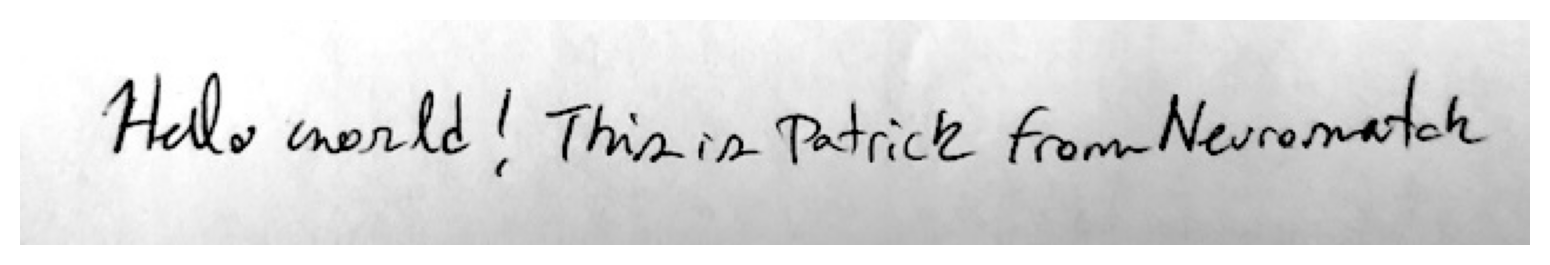

In [20]:
# Usage
image_path = 'img_1235.jpg'
display_image(image_path)

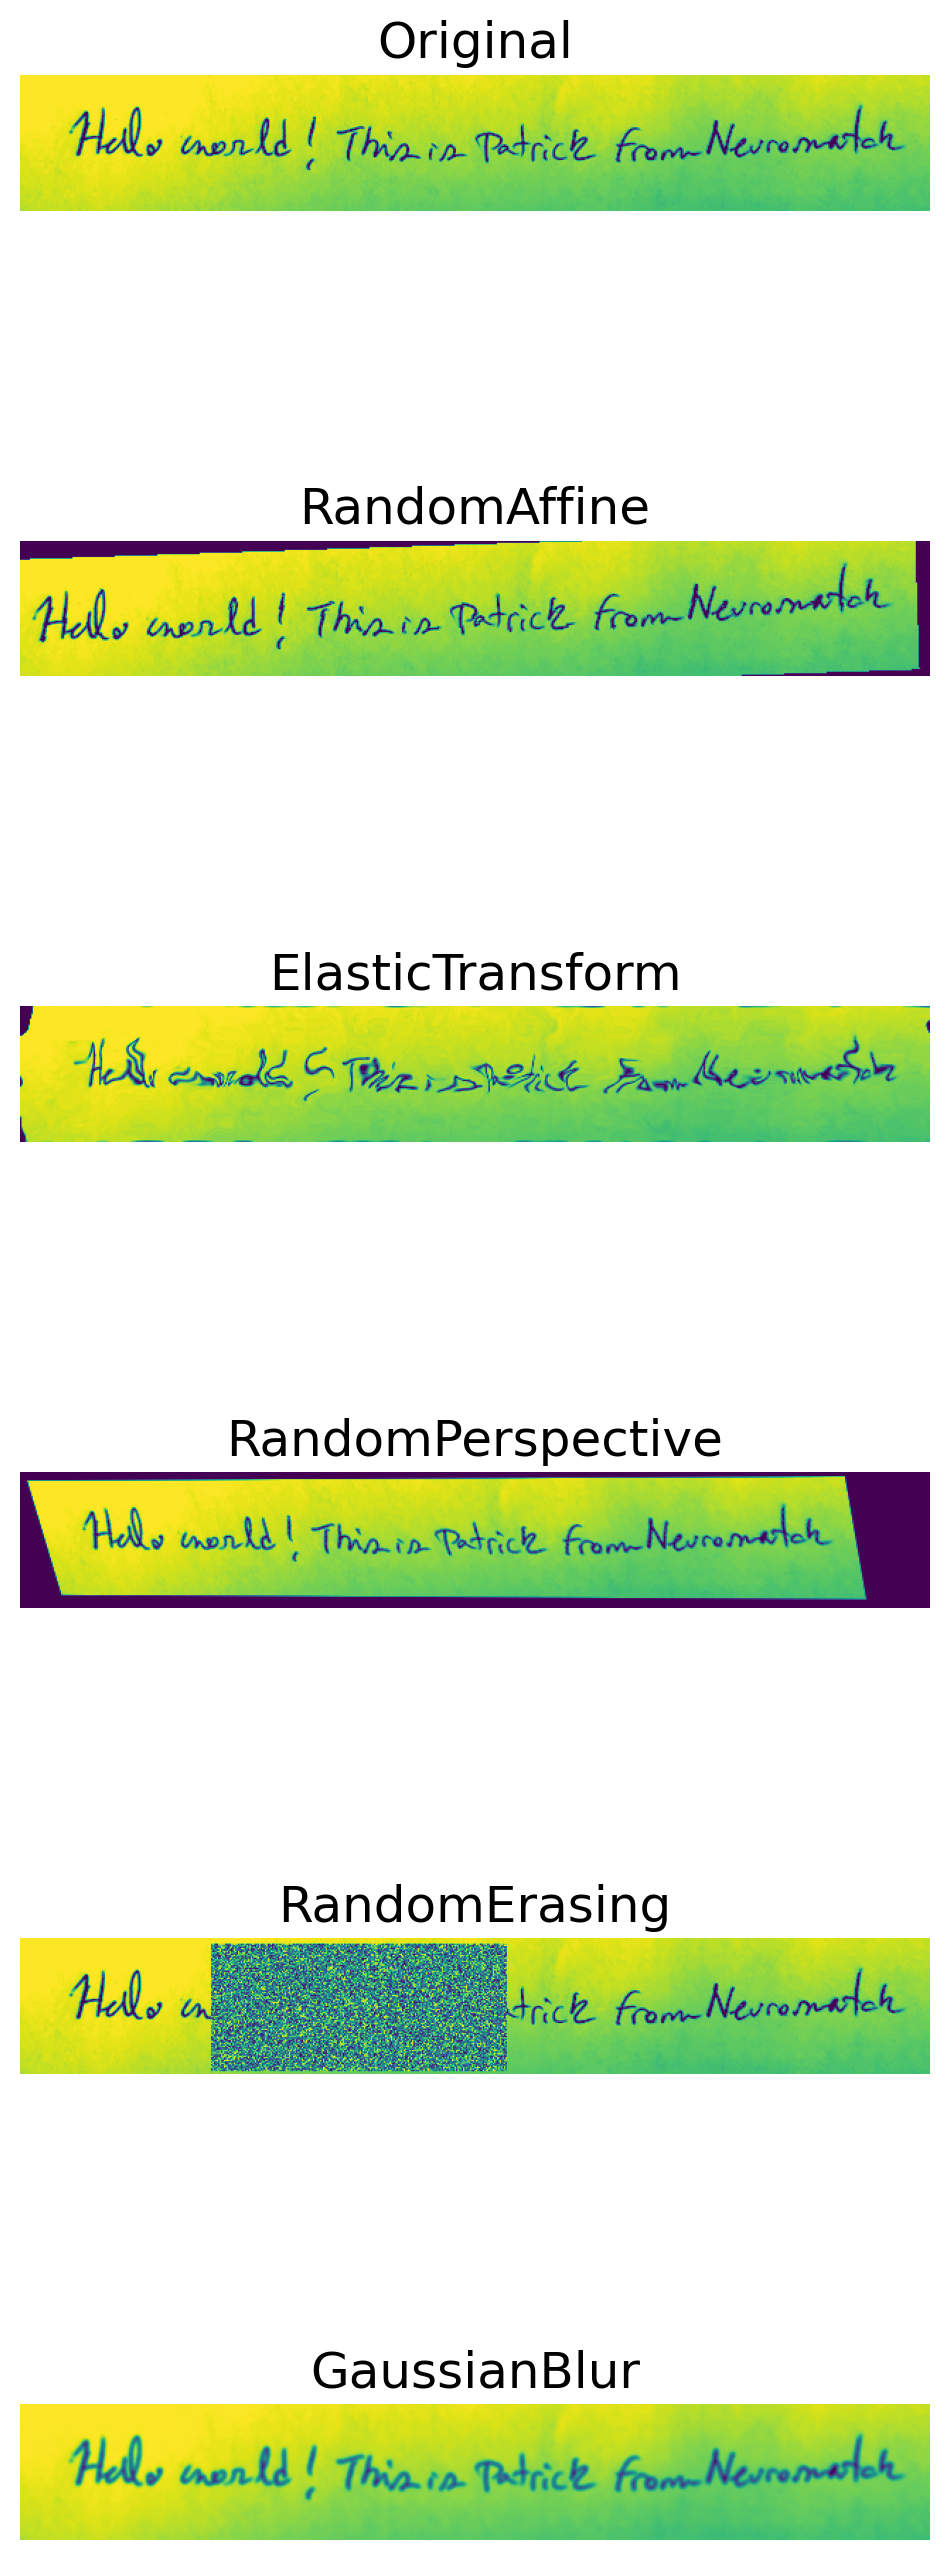

In [21]:
# Convert PIL Image to Tensor
image = Image.open(image_path)
image = transforms.ToTensor()(image)

# Define each transformation separately
# RandomAffine: applies rotations, translations, scaling. Here, rotates by up to ±15 degrees,
affine = transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1))

# ElasticTransform: applies elastic distortions to the image. The 'alpha' parameter controls
# the intensity of the distortion.
elastic = transforms.ElasticTransform(alpha=50.0)

# RandomPerspective: applies random perspective transformations with a specified distortion scale.
perspective = transforms.RandomPerspective(distortion_scale=0.2, p=1.0)

# RandomErasing: randomly erases a rectangle area in the image.
erasing = transforms.RandomErasing(p=1, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random', inplace=False)

# GaussianBlur: applies gaussian blur with specified kernel size and sigma range. 
gaussian_blur = transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.4, 5))

# A list of all transformations for iteration
transformations = [affine, elastic, perspective, erasing, gaussian_blur]

# Display
display_transformed_images(image, transformations)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


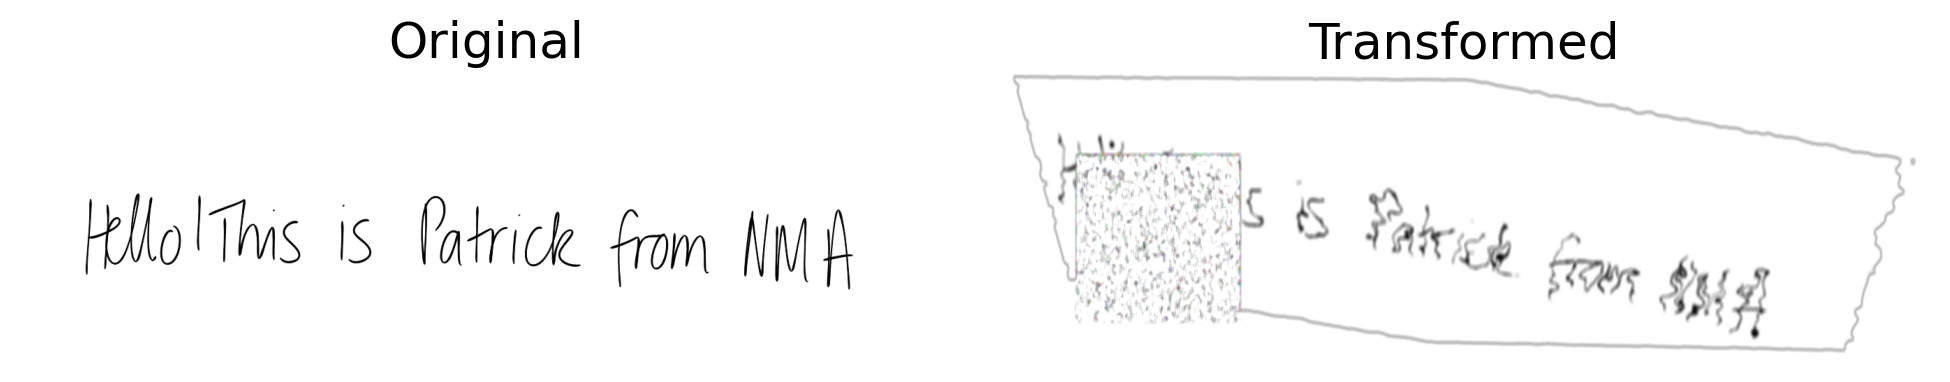

In [22]:
# Path to the image
image_path = 'image_augmentation.png'

# Open the image
image = Image.open(image_path)

# Convert PIL Image to Tensor
image_tensor = transforms.ToTensor()(image)

# Define transformations here
affine = transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1))
elastic = transforms.ElasticTransform(alpha=90.0)
perspective = transforms.RandomPerspective(distortion_scale=0.2, p=1.0)
erasing = transforms.RandomErasing(p=1, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random', inplace=False)
gaussian_blur = transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))

# Combine all the transformations
all_transforms = transforms.Compose([
    affine,
    elastic,
    perspective,
    erasing,
    gaussian_blur
])

# Apply combined transformation
augmented_image_tensor = all_transforms(image_tensor)

display_original_and_transformed_images(image_tensor, augmented_image_tensor)


In [23]:
## We preface this activity by discussing the limitations of real-world data and the role of 
# synthetic data in overcoming these barriers, particularly in domains like handwriting recognition where variability is vast.
## This segment sets the stage for participants to engage with synthetic data generation techniques, 
# exploring how they can extend the model's ability to generalize beyond its original training set.

In [26]:
# Define your strings
strings = ['Hello', 'This is Patrick', 'From NMA']

# Specify font path
font_path = "DancingScript-VariableFont_wght.ttf"  # Ensure this path is correct

# Create a generator with the specified parameters
generator = GeneratorFromStrings(
    strings=strings,
    fonts=[font_path],  # Use the path to the Dancing Script font
    space_width=2,
    skewing_angle=8,
    count=3
)

from PIL import Image

# Define the desired size
desired_size = (500, 300)  # Width, Height in pixels

# Function to resize images
def resize_image(image, new_size):
    return image.resize(new_size, Image.Resampling.LANCZOS)

for img, lbl in generator:
    # Resize the image before showing it
    img = resize_image(img, desired_size)
    img.show()

# Call the function with the generator
display_generated_images(generator)


<Figure size 1500x300 with 0 Axes>

In [25]:
IFrame("https://www.calligrapher.ai/", width=800, height=600)